### Installation des dépendances

In [ ]:
%pip install numpy
%pip install opencv-python
%pip install -U matplotlib
%pip install -U scikit-image
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as py
from numpy import linalg as LA
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import os
import time

# Transformée de KL

### Lecture des fichiers images

In [87]:
def plotImage(image, type):
    figure = py.figure(figsize = (10,10))
    imageout = np.clip(image,0,255)
    imageout= imageout.astype(type)
    py.imshow(imageout, cmap='gray')
    py.show()

In [225]:

# Read image
dataPath = "/data/"
currDirectory = os.getcwd()
fileList = os.listdir(currDirectory + dataPath)
quantificateur = [[8,8,8], [8,8,4], [8,8,0], [8,4,0]]
qualiteCompressionRGB = []
qualiteCompressionYUV = []

for file in fileList:
    imagePath = currDirectory + dataPath + file
    # img = py.imread(imagePath)
    img = cv.imread(imagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    if img is not None:
        YUVimage = cv.cvtColor(img, cv.COLOR_RGB2YUV)
        for q in quantificateur:
            imageKLTransforme = compression(img, q)
            imageYUVKLTransforme = compression(YUVimage, q)
            qualiteCompressionRGB.append(qualiteCompression(img, imageKLTransforme))
            qualiteCompressionYUV.append(qualiteCompression(YUVimage, imageYUVKLTransforme))
            # break
            
        print("qualité de compression RGB : pour l'image " + file, qualiteCompressionRGB)
        qualiteCompressionRGB = []
        print("qualité de compression YUV : pour l'image " + file, qualiteCompressionYUV)
        qualiteCompressionYUV = []
        # plotImage(img, 'uint8')
        # plotImage(imageKLTransforme, 'uint8')
        # break
    
   

qualité de compression RGB : pour l'image kodim01.png [(0.833, 19.109), (0.829, 18.943), (0.829, 18.951), (0.826, 18.936)]
qualité de compression YUV : pour l'image kodim01.png [(0.79, 23.13), (0.791, 23.123), (0.791, 23.123), (0.784, 23.092)]
qualité de compression RGB : pour l'image kodim02.png [(0.944, 22.586), (0.943, 22.584), (0.943, 22.576), (0.943, 22.526)]
qualité de compression YUV : pour l'image kodim02.png [(0.977, 27.301), (0.976, 27.276), (0.976, 27.276), (0.975, 27.066)]
qualité de compression RGB : pour l'image kodim05.png [(0.741, 16.079), (0.739, 16.067), (0.726, 16.018), (0.713, 15.955)]
qualité de compression YUV : pour l'image kodim05.png [(0.883, 23.294), (0.881, 23.259), (0.86, 22.641), (0.861, 22.63)]
qualité de compression RGB : pour l'image kodim13.png [(0.799, 15.195), (0.789, 15.174), (0.738, 15.036), (0.735, 15.034)]
qualité de compression YUV : pour l'image kodim13.png [(0.794, 22.999), (0.781, 22.949), (0.779, 22.947), (0.77, 22.893)]
qualité de compressio

## Question 2
### Implémentation de la transformée de KL 
### Quantification et recomposition de l'image

In [224]:
def compression(image, quantificateur: list):
    # Calcul de la moyenne
    sommeR = 0.0 
    sommeG = 0.0 
    sommeB = 0.0 
    for i in range(len(image)):
        for j in range(len(image[0])):
            sommeR=sommeR+image[i][j][0]
            sommeG=sommeG+image[i][j][1]
            sommeB=sommeB+image[i][j][2]
    nbPixels = len(image)*len(image[0])        
    MoyR= sommeR / nbPixels
    MoyG= sommeG / nbPixels
    MoyB= sommeB / nbPixels
    
    # calcul de la matrice de covariance
    covRGB = np.zeros((3,3), dtype = "double")
    for i in range(len(image)):
        for j in range(len(image[0])):
            vecTemp=[[image[i][j][0] - MoyR], [image[i][j][1]] - MoyG, [image[i][j][2] - MoyB]]
            vecProdTemp = np.dot(vecTemp,np.transpose(vecTemp))
            covRGB = np.add(covRGB,vecProdTemp)
    covRGB = covRGB / nbPixels  
    
    # Calcul des valeurs propres et vecteurs propres
    eigval, eigvec = LA.eig(covRGB)
    eigvec = np.transpose(eigvec)
    
    image_reshaped = image.reshape(-1, 3)  
    image_centered = image_reshaped - np.array([MoyR, MoyG, MoyB])
    
    imageKL = np.dot(image_centered, eigvec.T)  
    imageKL = imageKL.reshape(image.shape) 

    vecMoy = [[MoyR], [MoyG], [MoyB]]

    for i in range(len(image)):
        for j in range(len(image[0])):
            vecTemp = [[image[i][j][0]], [image[i][j][1]], [image[i][j][2]]]
            # a=Mb
            imageKL[i][j][:] = np.reshape(np.dot(eigvec, np.subtract(vecTemp, vecMoy)), (3))

    # Quantification
    imageKLQuantifie = quantize_image(imageKL, quantificateur)
    
    # convertir image KL quantifiée en image RGB
    imageReconvertie = np.copy(imageKLQuantifie)
    inv_eigvec = np.linalg.inv(eigvec)
    for i in range(len(imageKLQuantifie)):
        for j in range(len(imageKLQuantifie[0])):
            vecTemp = imageKLQuantifie[i, j].reshape(-1, 1)
            imageReconvertie[i, j] = np.dot(inv_eigvec, vecTemp).reshape(3) + np.array(vecMoy).reshape(3) 
                
    
    return imageReconvertie  

In [223]:
def qualiteCompression(imageOriginale, imageCompressee):
    psnr = peak_signal_noise_ratio(imageOriginale, imageCompressee)
    ssim = structural_similarity(imageOriginale, imageCompressee,  win_size=3, data_range=img.max() - img.min())
    return round(ssim, 3), round(psnr, 3)

In [222]:
def quantize_channel(channel, num_bits):
    num_levels = 2 ** num_bits

    quantization_interval = 256 / num_levels

    quantized_channel = np.round(channel / quantization_interval) * quantization_interval

    quantized_channel = np.clip(quantized_channel, 0, 255)

    return quantized_channel.astype(np.uint8)

def quantize_image(image, num_bits):
    r_channel, g_channel, b_channel = image[:,:,0], image[:,:,1], image[:,:,2]

    quantized_r = quantize_channel(r_channel, num_bits[0])
    quantized_g = quantize_channel(g_channel, num_bits[1])
    quantized_b = quantize_channel(b_channel, num_bits[2])

    quantized_image = np.stack((quantized_r, quantized_g, quantized_b), axis=-1)

    return quantized_image

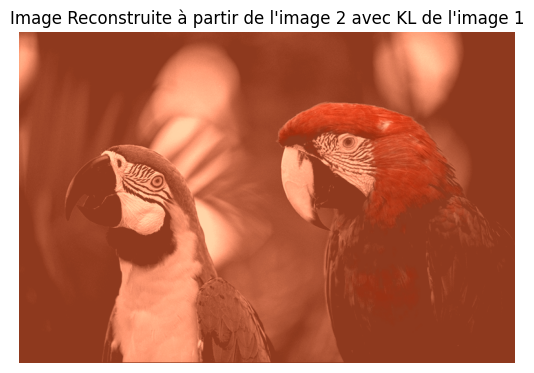

In [230]:
def compression2(image1, image2, quantificateur: list):
    YUVimage1 = cv.cvtColor(image1, cv.COLOR_BGR2YUV)
    YUVimage2 = cv.cvtColor(image2, cv.COLOR_BGR2YUV)
    
    # Application de la transformation de Karhunen-Loève sur iamge1
    sommeR = 0.0
    sommeG = 0.0
    sommeB = 0.0
    for i in range(len(YUVimage1)):
        for j in range(len(YUVimage1[0])):
            sommeR = sommeR + YUVimage1[i][j][0]
            sommeG = sommeG + YUVimage1[i][j][1]
            sommeB = sommeB + YUVimage1[i][j][2]

    nbPixels = len(YUVimage1) * len(YUVimage1[0])
    MoyR = sommeR / nbPixels
    MoyG = sommeG / nbPixels
    MoyB = sommeB / nbPixels

    covRGB = np.zeros((3, 3), dtype="double")
    for i in range(len(YUVimage1)):
        for j in range(len(YUVimage1[0])):
            vecTemp = [[YUVimage1[i][j][0] - MoyR], [YUVimage1[i][j][1] - MoyG], [YUVimage1[i][j][2] - MoyB]]
            vecProdTemp = np.dot(vecTemp, np.transpose(vecTemp))
            covRGB = np.add(covRGB, vecProdTemp)

    covRGB = covRGB / nbPixels

    eigval, eigvec = LA.eig(covRGB)

    eigvec = np.transpose(eigvec)


    vecMoy = [[MoyR], [MoyG], [MoyB]]

    image_reshaped = YUVimage1.reshape(-1, 3)  
    image_centered = image_reshaped - np.array([MoyR, MoyG, MoyB])  

    imageKL = np.dot(image_centered, eigvec.T)  
    imageKL = imageKL.reshape(YUVimage1.shape) 


    for i in range(len(YUVimage1)):
        for j in range(len(YUVimage1[0])):
            vecTemp = [[YUVimage1[i][j][0]], [YUVimage1[i][j][1]], [YUVimage1[i][j][2]]]
            # a=Mb
            imageKL[i][j][:] = np.reshape(np.dot(eigvec, np.subtract(vecTemp, vecMoy)), (3))
            
    # Quantification de l'image 2
    image_2_centered = YUVimage2.reshape(-1, 3) - np.array([MoyR, MoyG, MoyB])
    imageKL_2 = np.dot(image_2_centered, eigvec.T)
    imageKL_2 = imageKL_2.reshape(YUVimage2.shape)
    quantized_image_KL_2 = quantize_image(imageKL_2, quantificateur)
    
    
    reconstructed_image_KL_2 = np.zeros_like(quantized_image_KL_2, dtype='double')
    inv_eigvec = np.linalg.inv(eigvec)
    
    for i in range(len(quantized_image_KL_2)):
        for j in range(len(quantized_image_KL_2[0])):
            vecTemp = quantized_image_KL_2[i, j].reshape(-1, 1)
            reconstructed_image_KL_2[i, j] = np.dot(inv_eigvec, vecTemp).reshape(3) + np.array(vecMoy).reshape(3)
            
    reconstructed_image_KL_2 = cv.cvtColor(reconstructed_image_KL_2.astype('uint8'), cv.COLOR_YUV2RGB)
    py.imshow(reconstructed_image_KL_2.astype('uint8'))
    py.title('Image Reconstruite à partir de l\'image 2 avec KL de l\'image 1')
    py.axis('off')
    py.show()
    
compression2(cv.imread("./data/kodim02.png"), cv.imread("./data/kodim23.png"), [8, 8, 0])
    